# Projeto Final do Bootcamp LAMIA

## Esse projeto é de autoria de: Guilherme Loan Schneider

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
%pip install roboflow torch
%pip install ultralytics

In [ ]:
%pip install torch

In [ ]:
%pip install roboflow

In [2]:
from roboflow import Roboflow

In [2]:
# Baixando o modelo do Yolov11 small
from ultralytics import YOLO
model = YOLO("yolo11s.pt")

100%|██████████| 18.4M/18.4M [00:00<00:00, 23.8MB/s]


### Base de região de interesse (ROI)

In [1]:
# https://universe.roboflow.com/tugas-akhir-taaag/vin-good
from roboflow import Roboflow
rf = Roboflow(api_key="0loMwrWJPTNZUN1c2TEP")
project = rf.workspace("tugas-akhir-taaag").project("vin-good")
version = project.version(13)
VIN_completo = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


### Bases de cada caracter individual

In [3]:
# https://universe.roboflow.com/tugas-akhir-taaag/vin-2
rf = Roboflow(api_key="t71kG0dstvTXQmTEnHSH")
project = rf.workspace("tugas-akhir-taaag").project("vin-2")
version = project.version(5)
VIN_chars = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to VIN-2-5 in yolov11:: 100%|██████████| 1882/1882 [00:35<00:00, 52.88it/s]


In [1]:
# https://universe.roboflow.com/rafi-akbar-9hduc/tugas-akhir-hmrtn/dataset/2
from roboflow import Roboflow
rf = Roboflow(api_key="0loMwrWJPTNZUN1c2TEP")
project = rf.workspace("rafi-akbar-9hduc").project("tugas-akhir-hmrtn")
version = project.version(2)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Tugas-Akhir-2 in yolov11:: 100%|██████████| 1730/1730 [00:41<00:00, 41.93it/s]


In [4]:
# https://universe.roboflow.com/personal-sspf3/vin-tngcp-lmfcr/dataset/2#
from roboflow import Roboflow
rf = Roboflow(api_key="0loMwrWJPTNZUN1c2TEP")
project = rf.workspace("personal-sspf3").project("vin-tngcp-lmfcr")
version = project.version(2)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to VIN-2 in yolov11:: 100%|██████████| 4512/4512 [02:22<00:00, 31.67it/s] 


In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

# Aplicando pré-processamento no dataset

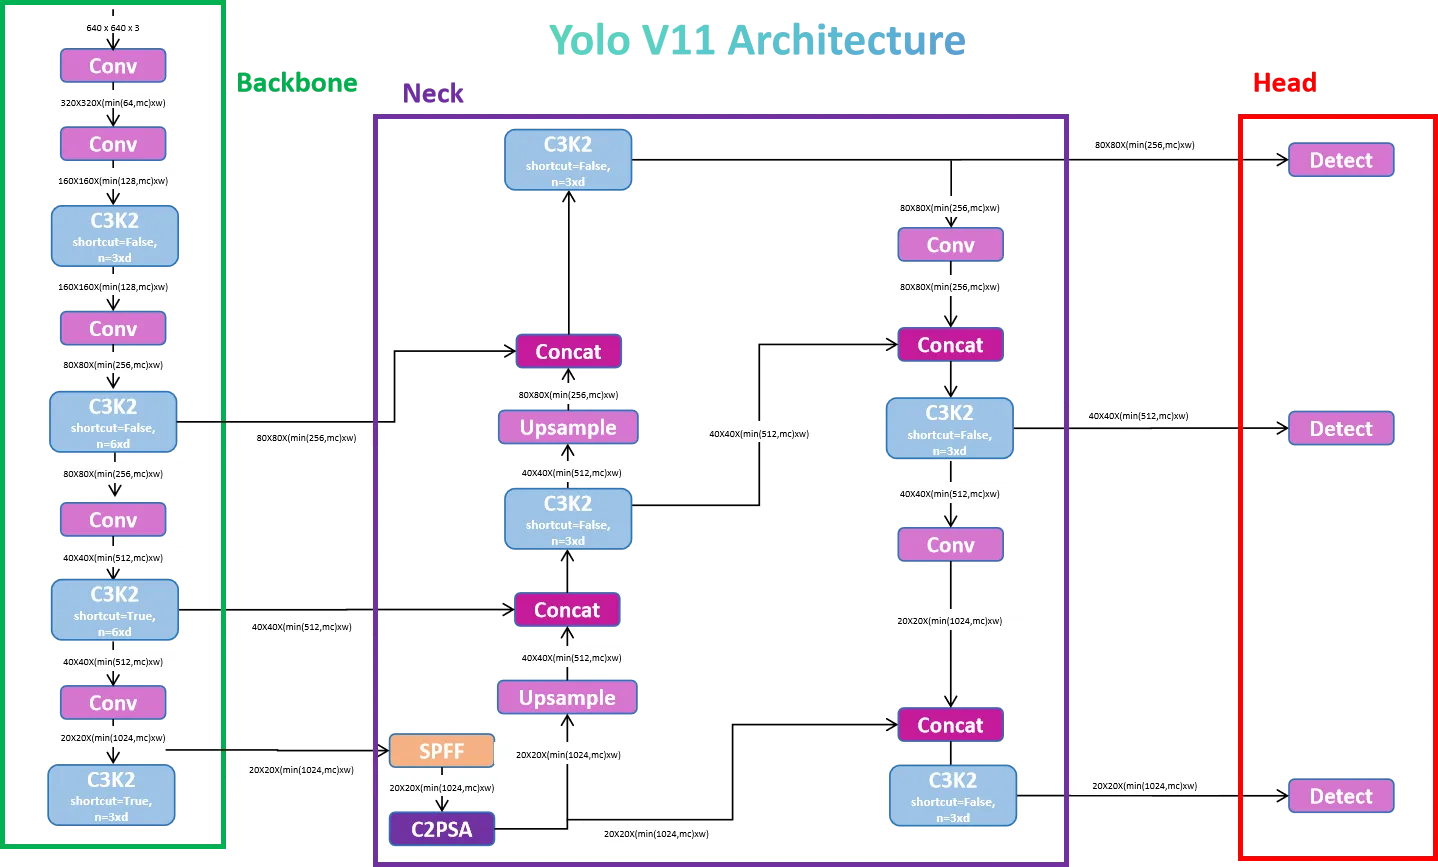

# Filtrando os dados para apenas com imagens que contenham 17 caracteres

In [ ]:
import os
import shutil

bases = {
    "VIN-2": "./VIN-2",
    "VIN-2-5": "./VIN-2-5",
}
output_base = "./merged_dataset_converted"
splits = ['train', 'valid', 'test']

def merge_datasets():
    for split in splits:
        img_dst = os.path.join(output_base, split, "images")
        lbl_dst = os.path.join(output_base, split, "labels")
        os.makedirs(img_dst, exist_ok=True)
        os.makedirs(lbl_dst, exist_ok=True)

        for base_name, base_path in bases.items():
            img_src = os.path.join(base_path, split, "images")
            lbl_src = os.path.join(base_path, split, "labels")

            if not (os.path.isdir(img_src) and os.path.isdir(lbl_src)):
                continue

            for fname in os.listdir(img_src):
                if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                label_file = os.path.splitext(fname)[0] + ".txt"
                label_path = os.path.join(lbl_src, label_file)

                if not os.path.isfile(label_path):
                    continue
                with open(label_path, "r") as f:
                    lines = f.readlines()
                if len(lines) != 17:
                    continue

                # Copia os arquivos com prefixo indicando a base
                new_img = f"{base_name}_{fname}"
                new_lbl = f"{base_name}_{os.path.splitext(fname)[0]}.txt"
                shutil.copy2(os.path.join(img_src, fname), os.path.join(img_dst, new_img))
                shutil.copy2(label_path, os.path.join(lbl_dst, new_lbl))

merge_datasets()

# Parte de correção dos datasets, junção e separação em conjunto de treino, teste e validação

In [ ]:
import os

final_classes = [
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','J','K',
    'L','M','N','P','R','S','T','U','V','W',
    'X','Y','Z'
]

# Dataset 1 original (37 classes)
classes_37 = [
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','I','J',
    'K','L','M','N','NORANG','NOSIN','O','P',
    'R','S','T','U','V','W','X','Y','Z'
]

# Dataset 2 original (35 classes)
classes_35 = [
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','I','J',
    'K','L','M','N','O','P','R','S','T','U',
    'V','W','X','Y','Z'
]

def build_class_map(old_classes):
    """Cria o mapeamento old_index -> new_index ou None (se deve ser removida)"""
    mapping = {}
    for idx, c in enumerate(old_classes):
        if c not in final_classes:
            mapping[idx] = None  # descartar
        else:
            mapping[idx] = final_classes.index(c)
    return mapping

map_37 = build_class_map(classes_37)
map_35 = build_class_map(classes_35)

print("Mapeamento dataset 37:", map_37)
print("Mapeamento dataset 35:", map_35)

# Corrigir os arquivos de labels
def fix_labels(dataset_path, mapping):
    splits = ['train', 'valid', 'test']
    for split in splits:
        lbl_dir = os.path.join(dataset_path, split, "labels")
        for fname in os.listdir(lbl_dir):
            if not fname.endswith(".txt"):
                continue

            fpath = os.path.join(lbl_dir, fname)
            new_lines = []
            with open(fpath, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue

                    old_cls = int(parts[0])
                    new_cls = mapping[old_cls]

                    if new_cls is None:
                        continue

                    parts[0] = str(new_cls)
                    new_lines.append(" ".join(parts))

            with open(fpath, "w") as f:
                f.write("\n".join(new_lines))

fix_labels("./VIN-2-5", map_35)

Mapeamento dataset 37: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: None, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: None, 25: None, 26: None, 27: 23, 28: 24, 29: 25, 30: 26, 31: 27, 32: 28, 33: 29, 34: 30, 35: 31, 36: 32}
Mapeamento dataset 35: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: None, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: None, 25: 23, 26: 24, 27: 25, 28: 26, 29: 27, 30: 28, 31: 29, 32: 30, 33: 31, 34: 32}


In [ ]:
import os
import shutil
import random

bases = {
    "VIN-2": "./VIN-2",
    "VIN-2-5": "./VIN-2-5",
}
output_base = "./merged_dataset_converted"
splits = ['train', 'valid', 'test']

# proporções
train_ratio = 0.65
test_ratio = 0.25
valid_ratio = 0.10

def merge_and_split():
    all_files = []

    # Coleta todos os pares (imagem, label) das bases
    for base_name, base_path in bases.items():
        for split in ['train', 'valid', 'test']:  # lê de qualquer split
            img_src = os.path.join(base_path, split, "images")
            lbl_src = os.path.join(base_path, split, "labels")

            if not (os.path.isdir(img_src) and os.path.isdir(lbl_src)):
                continue

            for fname in os.listdir(img_src):
                if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                label_file = os.path.splitext(fname)[0] + ".txt"
                label_path = os.path.join(lbl_src, label_file)

                if not os.path.isfile(label_path):
                    continue

                with open(label_path, "r") as f:
                    lines = f.readlines()
                if len(lines) != 17:
                    continue

                all_files.append((base_name, fname, label_file, img_src, lbl_src))

    # Embaralha para aleatorizar
    random.shuffle(all_files)

    n_total = len(all_files)
    n_train = int(n_total * train_ratio)
    n_test = int(n_total * test_ratio)
    n_valid = n_total - n_train - n_test

    train_files = all_files[:n_train]
    test_files = all_files[n_train:n_train+n_test]
    valid_files = all_files[n_train+n_test:]

    split_map = {
        'train': train_files,
        'test': test_files,
        'valid': valid_files
    }

    # Cria pastas e copia
    for split, files in split_map.items():
        img_dst = os.path.join(output_base, split, "images")
        lbl_dst = os.path.join(output_base, split, "labels")
        os.makedirs(img_dst, exist_ok=True)
        os.makedirs(lbl_dst, exist_ok=True)

        for base_name, img_name, lbl_name, img_src, lbl_src in files:
            new_img = f"{base_name}_{img_name}"
            new_lbl = f"{base_name}_{os.path.splitext(img_name)[0]}.txt"
            shutil.copy2(os.path.join(img_src, img_name), os.path.join(img_dst, new_img))
            shutil.copy2(os.path.join(lbl_src, lbl_name), os.path.join(lbl_dst, new_lbl))

    print(f"Total: {n_total} | Train: {n_train} | Test: {n_test} | Valid: {n_valid}")

merge_and_split()


Total: 1333 | Train: 866 | Test: 333 | Valid: 134


# Realizando o data augmentation no dataset dos VINs (apenas modelo do ROI)

In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm

# Caminhos
yaml_path = "merged_dataset_norang/data.yaml"  # seu dataset principal
base_dir = os.path.dirname(yaml_path)

input_images = os.path.join(base_dir, "train/images")
input_labels = os.path.join(base_dir, "train/labels")

output_images = os.path.join(base_dir, "train/images_aug") # MUDAR
output_labels = os.path.join(base_dir, "train/labels_aug") # MUDAR

os.makedirs(output_images, exist_ok=True)
os.makedirs(output_labels, exist_ok=True)

N_AUGS = 3  # Número de augmentações por imagem

# Augmentations sutis
augment = A.Compose([
    A.Affine(
        scale=(0.95, 1.05),
        translate_percent=(0.02, 0.02),
        rotate=(-3, 3),
        p=0.7
    ),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=0.5),
        A.MotionBlur(blur_limit=(3, 5), p=0.5),
    ], p=0.3),
    A.OneOf([
        A.ImageCompression(quality_range=(60, 95), p=0.5),
        A.GaussNoise(var_limit=(10.0, 30.0), p=0.5),
    ], p=0.3),
    A.CLAHE(clip_limit=(1, 3), tile_grid_size=(8, 8), p=0.2)
], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"], clip=True))

# Função para ler labels YOLO
def read_labels(label_path):
    bboxes, labels = [], []
    if not os.path.exists(label_path):
        return bboxes, labels
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, w, h = map(float, line.strip().split())
            bboxes.append([x, y, w, h])
            labels.append(int(cls))
    return bboxes, labels

# Função para clipar bboxes para [0, 1]
def clip_bbox(bbox):
    # YOLO: [x_center, y_center, width, height]
    x, y, w, h = bbox
    x = min(max(x, 0.0), 1.0)
    y = min(max(y, 0.0), 1.0)
    w = min(max(w, 0.0), 1.0)
    h = min(max(h, 0.0), 1.0)
    return [x, y, w, h]

# Função para salvar labels YOLO
def save_labels(label_path, bboxes, labels):
    with open(label_path, "w") as f:
        for bbox, cls in zip(bboxes, labels):
            clipped_bbox = clip_bbox(bbox)
            f.write(f"{cls} {clipped_bbox[0]} {clipped_bbox[1]} {clipped_bbox[2]} {clipped_bbox[3]}\n")

# Loop pelas imagens
for fname in tqdm(os.listdir(input_images)):
    if not fname.lower().endswith((".jpg", ".png", ".jpeg")):
        continue
    
    img_path = os.path.join(input_images, fname)
    label_path = os.path.join(input_labels, os.path.splitext(fname)[0] + ".txt")
    
    image = cv2.imread(img_path)
    h, w = image.shape[:2]
    
    bboxes, labels = read_labels(label_path)
    
    if not bboxes:
        continue
    
    for i in range(N_AUGS):
        augmented = augment(image=image, bboxes=bboxes, class_labels=labels)
        aug_img = augmented["image"]
        aug_bboxes = augmented["bboxes"]
        aug_labels = augmented["class_labels"]

        # Clip all bounding boxes to [0, 1]
        aug_bboxes = [clip_bbox(bbox) for bbox in aug_bboxes]

        out_img_path = os.path.join(output_images, f"aug{i}_{fname}")
        cv2.imwrite(out_img_path, aug_img)

        out_lbl_path = os.path.join(output_labels, f"aug{i}_{os.path.splitext(fname)[0]}.txt")
        save_labels(out_lbl_path, aug_bboxes, aug_labels)

print("Data augmentation salvo em:", output_images)


# Aplica o pré-processamento no dataset inteiro

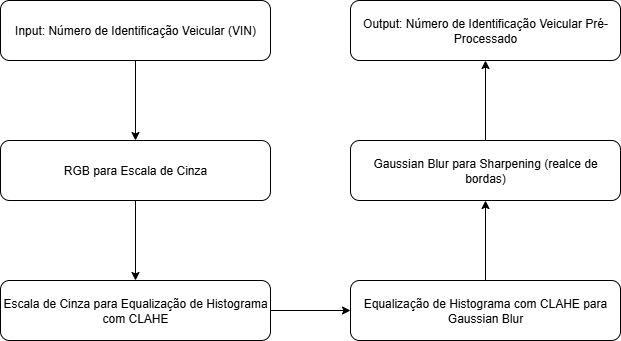

In [ ]:
import os
import cv2
import numpy as np
import shutil
from tqdm import tqdm

# --- Função de pré-processamento ---
def preprocess_full_image(image):
    # Converter para escala de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Suavização
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)

    # Sharpening
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, kernel)

    final_img = cv2.cvtColor(sharpened, cv2.COLOR_GRAY2BGR)
    return final_img

# --- Caminhos de entrada e saída ---
input_dataset = "./merged_dataset_norang"
output_dataset = "./merged_dataset_norang_preprocessed"

splits = ["train", "valid", "test"]

# --- Criação da estrutura do novo dataset ---
for split in splits:
    os.makedirs(os.path.join(output_dataset, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dataset, split, "labels"), exist_ok=True)

# --- Aplicação do pré-processamento ---
for split in splits:
    input_img_dir = os.path.join(input_dataset, split, "images")
    input_lbl_dir = os.path.join(input_dataset, split, "labels")
    output_img_dir = os.path.join(output_dataset, split, "images")
    output_lbl_dir = os.path.join(output_dataset, split, "labels")

    img_files = [f for f in os.listdir(input_img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    print(f"\nProcessando conjunto: {split} ({len(img_files)} imagens)")

    for img_name in tqdm(img_files, desc=f"Pré-processando {split}"):
        img_path = os.path.join(input_img_dir, img_name)
        out_img_path = os.path.join(output_img_dir, img_name)

        # Aplicar o pré-processamento
        image = cv2.imread(img_path)
        if image is None:
            print(f"Erro ao ler {img_path}")
            continue

        processed = preprocess_full_image(image)
        cv2.imwrite(out_img_path, processed)

        # Copiar label correspondente
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_src = os.path.join(input_lbl_dir, label_name)
        label_dst = os.path.join(output_lbl_dir, label_name)

        if os.path.exists(label_src):
            shutil.copy(label_src, label_dst)

print("\nPré-processamento completo! Novo dataset salvo em:")
print(f"{output_dataset}")

# Analisando o .txt das labels para ver se estão corretos

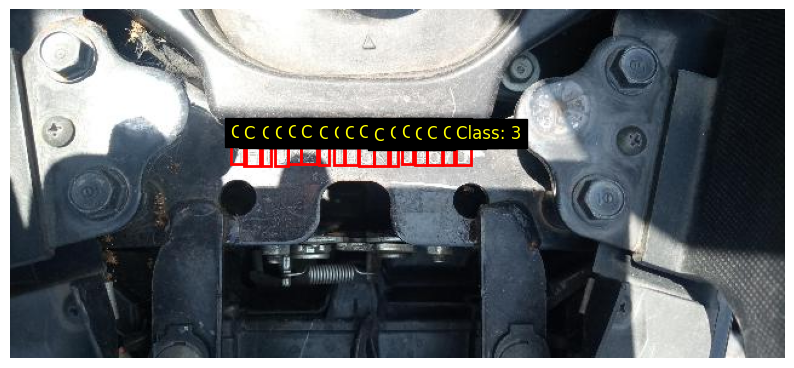

In [ ]:
import cv2
import matplotlib.pyplot as plt

def plot_image_with_labels(img_path, label_path):
    # Carrega a imagem
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w = image.shape[:2]

    # Lê as labels no formato YOLO: class x_center y_center width height
    boxes = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x, y, bw, bh = map(float, parts)
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)
            boxes.append((x1, y1, x2, y2, int(cls)))

    # Plota imagem e boxes
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()
    for x1, y1, x2, y2, cls in boxes:
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"Class: {cls}", color='yellow', fontsize=12, backgroundcolor='black')
    plt.axis('off')
    plt.show()

plot_image_with_labels("./merged_dataset_converted/train/images/VIN-2-5_D6621SAY-NO-RANGKA_jpg.rf.58de7a8b5a7c07e1104682d084b21341.jpg"
                       , "./merged_dataset_converted/train/labels/VIN-2-5_D6621SAY-NO-RANGKA_jpg.rf.58de7a8b5a7c07e1104682d084b21341.txt")


# Realizando o treinamento do ROI

In [2]:
from ultralytics import YOLO

# Caminho para o YAML do dataset de ROI
data_roi_yaml = 'merged_dataset_norang_preprocessed/data.yaml'

# Carrega o modelo YOLOv11 base
model_roi = YOLO('yolo11s.pt')

# Treinamento
model_roi.train(
    data=data_roi_yaml,
    epochs=35,
    imgsz=640,
    batch=16,
    workers=4,
    name='vin_roi_detection_preprocessed_dataset',
    augment=True
)

# Avaliação
metrics = model_roi.val()
print(metrics)

New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.135  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=merged_dataset_norang_preprocessed/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vin_roi_det

train: Scanning G:\My Drive\UTFPR\7o Período\Tcc 1\Códigos\merged_dataset_norang_preprocessed\train\labels... 2800 images, 266 backgrounds, 0 corrupt: 100%|██████████| 3066/3066 [00:14<00:00, 210.12it/s]


train: New cache created: G:\My Drive\UTFPR\7o Perodo\Tcc 1\Cdigos\merged_dataset_norang_preprocessed\train\labels.cache


C:\Users\guilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 1.00.4 ms, read: 32.131.6 MB/s, size: 460.9 KB)


val: Scanning G:\My Drive\UTFPR\7o Período\Tcc 1\Códigos\merged_dataset_norang_preprocessed\valid\labels... 333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 333/333 [00:02<00:00, 134.99it/s]


val: New cache created: G:\My Drive\UTFPR\7o Perodo\Tcc 1\Cdigos\merged_dataset_norang_preprocessed\valid\labels.cache
Plotting labels to runs\detect\vin_roi_detection_preprocessed_dataset\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs\detect\vin_roi_detection_preprocessed_dataset
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35         4G      1.581      2.227      1.374         21        640: 100%|██████████| 192/192 [02:00<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.18it/s]

                   all        333        333      0.913      0.904      0.941      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      4.03G      1.566      1.322      1.361         26        640: 100%|██████████| 192/192 [02:14<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]

                   all        333        333      0.793      0.839      0.864      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      4.03G      1.507      1.243      1.331         22        640: 100%|██████████| 192/192 [02:41<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.16s/it]

                   all        333        333      0.915       0.94      0.971       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      4.03G      1.426      1.143      1.286         27        640: 100%|██████████| 192/192 [02:43<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]

                   all        333        333      0.844      0.831      0.907      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      4.03G      1.323      1.064      1.221         29        640: 100%|██████████| 192/192 [02:43<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.10s/it]

                   all        333        333      0.959      0.937      0.983      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      4.03G       1.26     0.9827      1.185         26        640: 100%|██████████| 192/192 [02:47<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]

                   all        333        333       0.96      0.964      0.986      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      4.03G      1.237     0.9589      1.167         25        640: 100%|██████████| 192/192 [02:44<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]

                   all        333        333      0.976      0.963      0.984      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      4.03G      1.189     0.9268      1.142         22        640: 100%|██████████| 192/192 [02:51<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.10s/it]

                   all        333        333      0.991      0.968      0.989       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      4.03G      1.143     0.8717      1.125         16        640: 100%|██████████| 192/192 [02:46<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        333        333      0.974      0.958      0.987      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      4.03G      1.136     0.8694      1.122         19        640: 100%|██████████| 192/192 [02:52<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.10s/it]

                   all        333        333      0.979      0.975      0.994      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      4.03G      1.094     0.8348      1.097         27        640: 100%|██████████| 192/192 [02:46<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        333        333      0.991      0.962      0.992      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      4.03G      1.084     0.8151       1.08         24        640: 100%|██████████| 192/192 [02:54<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]

                   all        333        333      0.986      0.958      0.991      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      4.03G      1.046     0.7921      1.072         27        640: 100%|██████████| 192/192 [02:51<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]

                   all        333        333      0.994      0.961      0.991      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      4.03G      1.039     0.8015      1.064         26        640: 100%|██████████| 192/192 [02:37<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.03it/s]

                   all        333        333      0.995      0.961       0.99      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      4.03G      1.022     0.7569      1.055         23        640: 100%|██████████| 192/192 [02:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]

                   all        333        333      0.976      0.976      0.993      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      4.03G      1.012     0.7485      1.045         25        640: 100%|██████████| 192/192 [02:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]

                   all        333        333      0.991      0.976      0.994      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      4.03G     0.9832     0.7269      1.037         20        640: 100%|██████████| 192/192 [02:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]

                   all        333        333       0.99      0.973      0.994      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      4.03G     0.9965     0.7379      1.046         27        640: 100%|██████████| 192/192 [02:32<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]

                   all        333        333      0.985      0.973      0.993      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      4.04G     0.9675     0.7188       1.03         16        640: 100%|██████████| 192/192 [02:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.12it/s]

                   all        333        333      0.991       0.97      0.991      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      4.03G      0.961     0.7014      1.029         27        640: 100%|██████████| 192/192 [02:37<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.03it/s]

                   all        333        333          1      0.969      0.993      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      4.03G     0.9397     0.7068      1.026         28        640: 100%|██████████| 192/192 [02:35<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]

                   all        333        333      0.991      0.984      0.995      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      4.03G      0.936       0.69      1.024         19        640: 100%|██████████| 192/192 [02:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.02it/s]

                   all        333        333       0.98      0.979      0.993      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      4.03G     0.9039     0.6705      1.007         25        640: 100%|██████████| 192/192 [02:35<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        333        333          1      0.976      0.994      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      4.03G     0.8811     0.6618      1.007         24        640: 100%|██████████| 192/192 [02:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        333        333      0.979       0.98      0.993      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      4.03G     0.8797      0.644     0.9929         19        640: 100%|██████████| 192/192 [02:34<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]

                   all        333        333      0.986      0.973      0.993      0.815


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      4.04G     0.7823     0.5424     0.9645          8        640: 100%|██████████| 192/192 [02:35<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        333        333      0.979      0.976      0.986      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      4.04G     0.7609     0.5289     0.9518          9        640: 100%|██████████| 192/192 [02:41<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]

                   all        333        333      0.981      0.954      0.981      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      4.04G     0.7356     0.5128     0.9406         10        640: 100%|██████████| 192/192 [02:37<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]

                   all        333        333      0.982      0.943      0.979      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      4.04G     0.7109     0.5048     0.9346          9        640: 100%|██████████| 192/192 [02:45<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        333        333      0.975      0.956      0.979      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      4.04G     0.6861      0.482      0.923         10        640: 100%|██████████| 192/192 [02:43<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.18s/it]

                   all        333        333       0.93      0.874      0.962      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      4.04G     0.6872     0.4596      0.926          9        640: 100%|██████████| 192/192 [02:44<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        333        333      0.975      0.947      0.983       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      4.04G     0.6672     0.4421     0.9163          9        640: 100%|██████████| 192/192 [02:47<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.09s/it]

                   all        333        333      0.963      0.952      0.979      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      4.04G     0.6519     0.4358     0.9141         10        640: 100%|██████████| 192/192 [02:48<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]

                   all        333        333      0.944       0.85      0.961      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      4.04G     0.6368     0.4171     0.9052         10        640: 100%|██████████| 192/192 [02:46<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.15s/it]

                   all        333        333      0.914      0.775      0.927      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      4.04G     0.6178     0.4155     0.9036          8        640: 100%|██████████| 192/192 [02:48<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        333        333      0.972      0.843       0.96      0.842



35 epochs completed in 1.677 hours.
Optimizer stripped from runs\detect\vin_roi_detection_preprocessed_dataset\weights\last.pt, 18.7MB
Optimizer stripped from runs\detect\vin_roi_detection_preprocessed_dataset\weights\best.pt, 18.7MB

Validating runs\detect\vin_roi_detection_preprocessed_dataset\weights\best.pt...
Ultralytics 8.3.135  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]


                   all        333        333      0.978      0.982      0.994      0.869
Speed: 0.4ms preprocess, 11.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\vin_roi_detection_preprocessed_dataset
Ultralytics 8.3.135  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.70.1 ms, read: 43.349.5 MB/s, size: 471.7 KB)


val: Scanning G:\My Drive\UTFPR\7o Período\Tcc 1\Códigos\merged_dataset_norang_preprocessed\valid\labels.cache... 333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 333/333 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.62it/s]


                   all        333        333       0.98      0.982      0.994       0.87
Speed: 0.3ms preprocess, 18.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\vin_roi_detection_preprocessed_dataset2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022ED708C150>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.030

# Testando os resultados do treino com uma imagem

In [ ]:
from ultralytics import YOLO
model = YOLO('./runs/detect/vin_roi_detection6/weights/best.pt')
results = model.predict(
    source='./merged_dataset_converted/train/images/VIN-2_D3592SAA-NO-RANGKA_jpg.rf.b0ac1bf212c2f676fbfb03c41ea5eef6.jpg',
    conf=0.5,
    save=True,
    save_txt=True,
    device=0
)

# Realizando o treinamento de cada caracter

### Utilizando o dataset convertido (Adaptação das labels que não estavam padronizadas (37 em um e 35 no outro))

In [1]:
from ultralytics import YOLO
# Caminho para o YAML do dataset de caracteres
data_chars_yaml = './merged_dataset_converted/data.yaml'

# Novo modelo YOLO para detectar caracteres
model_chars = YOLO('yolo11s.pt')

# Treinamento
model_chars.train(
    data=data_chars_yaml,
    epochs=80,
    imgsz=640,
    batch=16,
    name='vin_char_detection_chars_yolo11s'
)

# Avaliação'
metrics = model_chars.val()
print(metrics)

New https://pypi.org/project/ultralytics/8.3.199 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.135  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./merged_dataset_converted/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vin_char_detection

train: Scanning G:\My Drive\UTFPR\7o Período\Tcc 1\Códigos\merged_dataset_converted\train\labels.cache... 866 images, 0 backgrounds, 0 corrupt: 100%|██████████| 866/866 [00:00<?, ?it/s]
C:\Users\guilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 1.10.4 ms, read: 2.72.1 MB/s, size: 94.2 KB)


val: Scanning G:\My Drive\UTFPR\7o Período\Tcc 1\Códigos\merged_dataset_converted\valid\labels.cache... 134 images, 0 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]


Plotting labels to runs\detect\vin_char_detection_chars_yolo11s\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00027, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\vin_char_detection_chars_yolo11s
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      4.18G       1.95      3.999      1.212         80        640: 100%|██████████| 55/55 [01:21<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]

                   all        134       2278      0.536      0.172      0.107     0.0595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      4.29G      1.605      2.105      1.077         34        640: 100%|██████████| 55/55 [01:44<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]

                   all        134       2278       0.62      0.302      0.332        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80       4.3G      1.545       1.64      1.059         62        640: 100%|██████████| 55/55 [01:33<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]

                   all        134       2278      0.776      0.412      0.479      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      4.29G      1.502      1.376      1.063         52        640: 100%|██████████| 55/55 [01:48<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]

                   all        134       2278      0.689      0.524      0.554      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80       4.3G      1.445      1.218       1.04         48        640: 100%|██████████| 55/55 [01:30<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]

                   all        134       2278      0.756      0.547      0.605      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      4.32G      1.396      1.092      1.025         69        640: 100%|██████████| 55/55 [02:00<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]

                   all        134       2278      0.865      0.554       0.67      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      4.29G      1.368      1.043      1.011         58        640: 100%|██████████| 55/55 [02:01<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]

                   all        134       2278      0.849      0.603      0.715      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80       4.3G      1.371      1.064      1.015         33        640: 100%|██████████| 55/55 [01:58<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]

                   all        134       2278      0.844      0.677      0.736      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      4.21G      1.317     0.9583      1.002         84        640: 100%|██████████| 55/55 [01:37<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]

                   all        134       2278      0.783      0.691      0.738      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      4.32G      1.324     0.9217      1.004         51        640: 100%|██████████| 55/55 [02:07<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]

                   all        134       2278      0.869      0.654      0.749      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      4.25G      1.318     0.8874     0.9973         63        640: 100%|██████████| 55/55 [01:28<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]

                   all        134       2278      0.852      0.701      0.765      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      4.29G      1.304     0.9183     0.9896         32        640: 100%|██████████| 55/55 [01:37<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]

                   all        134       2278      0.838      0.689      0.779      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      4.33G      1.264     0.8433     0.9823         35        640: 100%|██████████| 55/55 [01:37<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]

                   all        134       2278      0.876      0.735       0.79       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      4.28G      1.268     0.8486     0.9796         58        640: 100%|██████████| 55/55 [01:43<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]

                   all        134       2278      0.884      0.693      0.779      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      4.31G      1.221     0.7854     0.9676         51        640: 100%|██████████| 55/55 [01:41<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]

                   all        134       2278      0.931      0.698      0.803      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80       4.3G      1.248      0.801     0.9807        102        640: 100%|██████████| 55/55 [01:54<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


                   all        134       2278      0.873      0.736      0.806      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      4.32G      1.244     0.7987     0.9721         32        640: 100%|██████████| 55/55 [02:06<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


                   all        134       2278      0.881      0.697      0.801      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80       4.3G      1.204     0.7619     0.9673         22        640: 100%|██████████| 55/55 [01:34<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.60s/it]

                   all        134       2278      0.909      0.735      0.812      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      4.28G        1.2     0.7537     0.9545         43        640: 100%|██████████| 55/55 [01:51<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]

                   all        134       2278      0.899      0.746      0.818      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      4.26G      1.217     0.7778     0.9584         53        640: 100%|██████████| 55/55 [01:26<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]

                   all        134       2278      0.935      0.724      0.818      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      4.29G      1.179      0.742     0.9562         32        640: 100%|██████████| 55/55 [01:32<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]

                   all        134       2278      0.899      0.736      0.813      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      4.31G      1.169     0.7321     0.9531         39        640: 100%|██████████| 55/55 [02:04<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]

                   all        134       2278       0.79      0.791      0.842       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      4.27G      1.147     0.7095     0.9416         47        640: 100%|██████████| 55/55 [01:51<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]

                   all        134       2278      0.928       0.79      0.864       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80       4.2G      1.142     0.7123     0.9454         55        640: 100%|██████████| 55/55 [01:30<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]

                   all        134       2278      0.897        0.8      0.872      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      4.29G      1.129     0.7032     0.9404         46        640: 100%|██████████| 55/55 [01:28<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]

                   all        134       2278      0.859      0.806      0.861      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80       4.3G      1.103     0.6681     0.9309         74        640: 100%|██████████| 55/55 [01:49<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]

                   all        134       2278      0.883      0.815      0.864      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      4.26G      1.127      0.677     0.9372         33        640: 100%|██████████| 55/55 [01:34<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


                   all        134       2278      0.941      0.748      0.864       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      4.33G      1.092     0.6587     0.9273         31        640: 100%|██████████| 55/55 [01:50<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]

                   all        134       2278      0.933      0.793      0.888      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      4.32G      1.101     0.6688     0.9288         71        640: 100%|██████████| 55/55 [02:09<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]

                   all        134       2278      0.831      0.861      0.904      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      4.33G      1.094     0.6688     0.9263         97        640: 100%|██████████| 55/55 [02:05<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

                   all        134       2278      0.933      0.778      0.887      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      4.29G      1.059     0.6384     0.9141         70        640: 100%|██████████| 55/55 [02:02<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]

                   all        134       2278      0.931      0.763      0.908      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      4.24G      1.089     0.6397     0.9283         59        640: 100%|██████████| 55/55 [01:33<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]

                   all        134       2278      0.905      0.828      0.922      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      4.28G      1.068     0.6248     0.9285         54        640: 100%|██████████| 55/55 [01:39<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]

                   all        134       2278      0.963       0.75      0.877      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      4.25G      1.054     0.6102     0.9187         45        640: 100%|██████████| 55/55 [01:29<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]

                   all        134       2278      0.923       0.82      0.914      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      4.29G      1.041      0.615     0.9116         30        640: 100%|██████████| 55/55 [02:00<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]

                   all        134       2278      0.905      0.839      0.922      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      4.32G      1.039     0.6194     0.9186         34        640: 100%|██████████| 55/55 [02:05<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]

                   all        134       2278      0.911      0.798      0.904       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      4.25G      1.054     0.6432     0.9124         75        640: 100%|██████████| 55/55 [01:24<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]

                   all        134       2278       0.85      0.881      0.914      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      4.26G      1.023     0.6035     0.9066         69        640: 100%|██████████| 55/55 [01:31<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]

                   all        134       2278      0.857      0.883      0.933       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      4.26G     0.9992     0.5887      0.903         46        640: 100%|██████████| 55/55 [01:32<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]

                   all        134       2278      0.947      0.838      0.936      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80       4.3G     0.9989     0.5868      0.902         89        640: 100%|██████████| 55/55 [02:17<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]

                   all        134       2278      0.944      0.797      0.891      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      4.24G     0.9924     0.5865     0.9041         32        640: 100%|██████████| 55/55 [01:30<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]

                   all        134       2278      0.946      0.803      0.915      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80       4.3G      1.007      0.595     0.8989         70        640: 100%|██████████| 55/55 [01:32<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]

                   all        134       2278      0.915      0.874       0.92      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      4.31G          1     0.5972     0.9017         32        640: 100%|██████████| 55/55 [02:02<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]

                   all        134       2278       0.95      0.844      0.936      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      4.32G     0.9661     0.5731     0.8911         59        640: 100%|██████████| 55/55 [01:55<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


                   all        134       2278      0.921      0.879       0.94      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      4.28G     0.9875     0.5841     0.8984         39        640: 100%|██████████| 55/55 [01:57<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

                   all        134       2278      0.923      0.891      0.947      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      4.33G     0.9718     0.5719     0.8972         28        640: 100%|██████████| 55/55 [02:11<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]

                   all        134       2278      0.901      0.887      0.941      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      4.27G     0.9544     0.5524     0.8897         70        640: 100%|██████████| 55/55 [01:54<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]

                   all        134       2278      0.948      0.865      0.941      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      4.33G     0.9481     0.5609     0.8849         98        640: 100%|██████████| 55/55 [02:04<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


                   all        134       2278      0.937      0.866      0.946      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      4.29G     0.9346     0.5637     0.8893         47        640: 100%|██████████| 55/55 [01:52<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]

                   all        134       2278      0.952      0.863      0.945       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      4.33G     0.9402     0.5517     0.8909         47        640: 100%|██████████| 55/55 [02:09<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]

                   all        134       2278      0.943      0.854      0.947      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      4.31G     0.9506     0.5703      0.885         79        640: 100%|██████████| 55/55 [02:06<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]

                   all        134       2278      0.944      0.883      0.945      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      4.33G     0.9228     0.5496     0.8867         49        640: 100%|██████████| 55/55 [02:02<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]

                   all        134       2278      0.929      0.889      0.948      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      4.28G     0.9354     0.5533     0.8822        108        640: 100%|██████████| 55/55 [01:19<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]

                   all        134       2278      0.953      0.864      0.948      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      4.27G      0.898     0.5259     0.8773         87        640: 100%|██████████| 55/55 [01:34<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]

                   all        134       2278      0.951      0.862       0.95      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      4.29G     0.9107     0.5396     0.8789         90        640: 100%|██████████| 55/55 [01:25<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]

                   all        134       2278      0.944      0.879       0.95      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80       4.3G     0.9029     0.5255      0.878         60        640: 100%|██████████| 55/55 [01:53<00:00,  2.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]

                   all        134       2278      0.934      0.887      0.949      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80       4.3G     0.8825     0.5124     0.8785         47        640: 100%|██████████| 55/55 [01:50<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]

                   all        134       2278      0.946      0.874      0.951      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80       4.2G     0.8824     0.5206     0.8741         65        640: 100%|██████████| 55/55 [01:52<00:00,  2.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]

                   all        134       2278      0.954      0.873      0.953      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80       4.2G     0.8859     0.5105     0.8786         41        640: 100%|██████████| 55/55 [01:55<00:00,  2.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]

                   all        134       2278      0.951      0.874      0.951      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      4.32G     0.9006     0.5354      0.875        101        640: 100%|██████████| 55/55 [01:36<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]

                   all        134       2278      0.952      0.875       0.95       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      4.28G     0.8875     0.5238      0.873         94        640: 100%|██████████| 55/55 [01:55<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]

                   all        134       2278      0.948      0.878      0.951      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      4.25G       0.88     0.5146     0.8696         33        640: 100%|██████████| 55/55 [01:41<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]

                   all        134       2278      0.949      0.877       0.95      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      4.27G     0.8815     0.5186     0.8722         32        640: 100%|██████████| 55/55 [01:49<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]

                   all        134       2278      0.943      0.887       0.95      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      4.32G     0.8663      0.509     0.8726         57        640: 100%|██████████| 55/55 [01:59<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]

                   all        134       2278      0.936      0.892       0.95      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      4.29G     0.8702     0.5209     0.8656         51        640: 100%|██████████| 55/55 [01:58<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]

                   all        134       2278      0.954      0.884      0.953      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      4.31G     0.8442     0.4969     0.8655         57        640: 100%|██████████| 55/55 [01:21<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]

                   all        134       2278      0.933      0.889      0.952      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      4.28G      0.866     0.5111     0.8688         64        640: 100%|██████████| 55/55 [01:53<00:00,  2.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


                   all        134       2278      0.949      0.887      0.956      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      4.31G     0.8344      0.489     0.8629         34        640: 100%|██████████| 55/55 [02:14<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.61s/it]

                   all        134       2278      0.941      0.891      0.955      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      4.32G     0.8409     0.4945     0.8637         73        640: 100%|██████████| 55/55 [02:10<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]

                   all        134       2278       0.95      0.883      0.957      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      4.32G     0.8428      0.509     0.8647         28        640: 100%|██████████| 55/55 [01:37<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]

                   all        134       2278      0.947      0.891      0.957      0.708


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      4.12G     0.8401     0.4674     0.8742         34        640: 100%|██████████| 55/55 [01:38<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

                   all        134       2278      0.958      0.871      0.949      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      4.14G     0.8059     0.4452     0.8676         32        640: 100%|██████████| 55/55 [01:13<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


                   all        134       2278      0.962      0.879       0.95      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      4.13G     0.8079     0.4494     0.8654         34        640: 100%|██████████| 55/55 [01:40<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


                   all        134       2278      0.947      0.895       0.95      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      4.14G     0.7943     0.4517      0.863         34        640: 100%|██████████| 55/55 [00:53<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

                   all        134       2278      0.948      0.894      0.951      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      4.12G     0.7898     0.4438     0.8653         34        640: 100%|██████████| 55/55 [00:51<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]

                   all        134       2278      0.954      0.886      0.951      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      4.14G     0.7811     0.4378     0.8609         34        640: 100%|██████████| 55/55 [01:00<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]

                   all        134       2278      0.952       0.89      0.954       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      4.13G     0.7695     0.4313     0.8591         34        640: 100%|██████████| 55/55 [01:45<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

                   all        134       2278      0.959      0.882      0.955       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      4.14G     0.7708     0.4294     0.8597         34        640: 100%|██████████| 55/55 [00:51<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]

                   all        134       2278      0.954      0.889      0.955      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      4.12G     0.7676     0.4265     0.8585         34        640: 100%|██████████| 55/55 [01:46<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]

                   all        134       2278      0.953      0.891      0.955       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      4.14G     0.7579     0.4239     0.8547         34        640: 100%|██████████| 55/55 [01:04<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]

                   all        134       2278      0.954      0.892      0.955      0.711



80 epochs completed in 2.493 hours.
Optimizer stripped from runs\detect\vin_char_detection_chars_yolo11s\weights\last.pt, 18.8MB
Optimizer stripped from runs\detect\vin_char_detection_chars_yolo11s\weights\best.pt, 18.8MB

Validating runs\detect\vin_char_detection_chars_yolo11s\weights\best.pt...
Ultralytics 8.3.135  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,425,571 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


                   all        134       2278      0.955      0.888      0.955      0.712
                     0         97        180      0.953      0.907      0.961      0.708
                     1        117        354      0.981      0.861      0.952      0.623
                     2         89        145      0.986      0.938      0.989      0.757
                     3         82        132      0.982      0.833      0.955      0.711
                     4         79        113      0.985      0.912      0.969      0.687
                     5         70         97      0.985      0.907      0.969       0.75
                     6         75        104      0.987      0.913      0.958      0.676
                     7         67         82      0.974        0.9      0.967       0.69
                     8         72        103      0.963      0.883      0.965      0.725
                     9         71         95      0.976      0.873      0.962      0.699
                     

val: Scanning G:\My Drive\UTFPR\7o Período\Tcc 1\Códigos\merged_dataset_converted\valid\labels.cache... 134 images, 0 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


                   all        134       2278      0.949      0.894      0.955      0.708
                     0         97        180      0.959      0.911      0.961       0.71
                     1        117        354      0.975      0.881      0.951      0.627
                     2         89        145      0.974      0.938      0.988      0.759
                     3         82        132      0.974      0.856       0.96      0.713
                     4         79        113      0.959       0.92      0.975      0.688
                     5         70         97      0.991      0.897       0.97      0.753
                     6         75        104       0.96      0.914      0.959      0.675
                     7         67         82      0.974      0.911      0.968      0.695
                     8         72        103      0.979      0.902      0.968      0.729
                     9         71         95      0.965      0.884      0.962      0.699
                     

In [ ]:
from ultralytics import YOLO
model = YOLO('./runs/detect/vin_char_detection_vin-2-5/weights/best.pt')
results = model.predict(
    source='VIN-(Good)-13/train/images/',
    conf=0.5,
    save=True,
    save_txt=True,
    device=0
)

metrics = model.val()
print(metrics)

In [12]:
# Carregando o modelo treinado para verificar as métricas
from ultralytics import YOLO
model = YOLO('./runs/detect/vin_char_detection_chars_yolo11s/weights/best.pt')
# Verificando as métricas
metrics = model.val()
print(metrics)

Ultralytics 8.3.140  Python-3.12.10 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8187MiB)
YOLO11s summary (fused): 100 layers, 9,425,571 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 1.80.4 ms, read: 5.14.4 MB/s, size: 104.5 KB)


val: Scanning G:\Meu Drive\UTFPR\7o Período\Tcc 1\Códigos\merged_dataset_converted\valid\labels... 134 images, 0 backgrounds, 0 corrupt: 100%|██████████| 134/134 [00:03<00:00, 42.46it/s]


val: New cache created: G:\Meu Drive\UTFPR\7o Perodo\Tcc 1\Cdigos\merged_dataset_converted\valid\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


                   all        134       2278      0.951      0.894      0.955      0.708
                     0         97        180      0.959      0.909      0.961      0.711
                     1        117        354      0.978      0.878      0.951      0.625
                     2         89        145      0.982      0.938      0.988      0.761
                     3         82        132      0.974      0.854       0.96      0.714
                     4         79        113      0.979       0.92       0.97      0.687
                     5         70         97      0.992      0.897       0.97      0.751
                     6         75        104      0.967      0.923      0.959      0.675
                     7         67         82      0.974       0.91      0.968      0.695
                     8         72        103      0.979      0.891      0.967      0.728
                     9         71         95      0.968      0.884      0.962      0.696
                     

# Realizando os processos para treinar a classificação de cada caracter

### Recortando cada caracter das imagens e salvando em uma pasta com o respectivo caracter

# Aplicando o pipeline completo

In [ ]:
import cv2
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO
import torch
import torchvision.ops as ops

# Paths
ROI_MODEL_PATH = './runs/detect/vin_roi_detection5/weights/best.pt'  # modelo YOLO para detectar VIN
CLASSIFIER_MODEL_PATH = 'vin_char_classifier+augmentation_2.pth'  # modelo CRNN ou ResNet
CLASSES_PATH = 'vin_characters_crops_merged-dataset2/'  # para obter a lista de classes

# Transformação para classificador
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carregar classificador
from torchvision import models
classifier = models.resnet18(pretrained=False)
classifier.fc = torch.nn.Linear(classifier.fc.in_features, len(os.listdir(CLASSES_PATH)))
classifier.load_state_dict(torch.load(CLASSIFIER_MODEL_PATH, map_location=device))
classifier.to(device)
classifier.eval()

char_classes = sorted(os.listdir(CLASSES_PATH))

# Carregar detector de ROI
detector = YOLO(ROI_MODEL_PATH)

def refine_vin_predictions(boxes, class_names, image_width, max_chars=17, iou_thresh=0.3):
    """
    Refina as detecções dos caracteres:
    - Remove sobreposições via NMS (IoU)
    - Ordena da esquerda para a direita
    - Retorna VIN com no máximo 17 caracteres
    
    Args:
        boxes (ultralytics.results.Boxes): caixas preditas pelo YOLO
        class_names (dict): dicionário {id: label}, ex: {0: 'A', 1: 'B', ..., 35: '9'}
        image_width (int): largura da imagem para checagens
        max_chars (int): máximo de caracteres no VIN (default: 17)
        iou_thresh (float): limiar para filtrar sobreposição (default: 0.3)
    
    Returns:
        vin_string (str): VIN final com no máximo 17 caracteres
    """
    if len(boxes) == 0:
        return ""

    # Convert boxes para tensores (formato xyxy)
    box_coords = torch.stack([b.xyxy[0] for b in boxes])
    scores = torch.tensor([b.conf[0].item() for b in boxes])

    # NMS para remover sobreposição
    keep = ops.nms(box_coords, scores, iou_threshold=iou_thresh)
    filtered_boxes = [boxes[i] for i in keep]

    # Agrupar: (x_position, predicted_char, confidence)
    char_preds = []
    for b in filtered_boxes:
        cls_id = int(b.cls.item())
        conf = float(b.conf.item())
        label = class_names.get(cls_id, '?')
        x_center = (b.xyxy[0][0] + b.xyxy[0][2]) / 2  # centro x
        char_preds.append((x_center.item(), label, conf))

    # Ordenar da esquerda para a direita e por confiança (em caso de empate de posição)
    char_preds = sorted(char_preds, key=lambda x: (x[0], -x[2]))

    # Pegar no máximo os N mais confiáveis da esquerda para a direita
    vin_chars = [char for _, char, _ in char_preds[:max_chars]]

    # Juntar os caracteres
    vin_string = ''.join(vin_chars)

    return vin_string

# Rotação automática baseada em OCR
def correct_orientation(image, roi_model):
    """
    Corrige a orientação da imagem usando o modelo YOLO de ROI (VIN).
    Gira a imagem se a caixa de detecção estiver em posição vertical.
    """
    for angle in [0, 90, 180, 270]:
        # Rotacionar a imagem
        rotated = cv2.rotate(image, {
            0: None,
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle]) if angle != 0 else image

        results = roi_model(rotated)[0]

        if not results.boxes:
            continue  # sem ROI detectada

        x1, y1, x2, y2 = map(int, results.boxes[0].xyxy[0])
        width, height = x2 - x1, y2 - y1

        # Critério simples: se estiver "em pé", rotaciona
        if width > height:
            return rotated, results  # imagem já está orientada corretamente
        # Senão, continua tentando outro ângulo

    return image, None  # fallback se nenhuma caixa correta for detectada

# Pipeline completo
def process_image(image_path):
    print(f"\n🖼️ Processando: {image_path}")

    image = cv2.imread(image_path)
    image_oriented, roi_result = correct_orientation(image, detector)

    # Usar a primeira bounding box da ROI detectada
    if not roi_result or not roi_result.boxes:
        print("❌ Nenhuma ROI detectada após correção.")
        return

    x1, y1, x2, y2 = map(int, roi_result.boxes[0].xyxy[0])
    vin_roi = image_oriented[y1:y2, x1:x2]
    if vin_roi.size == 0:
        print("❌ Recorte ROI vazio.")
        return

    # (Opcional) Salvar ou visualizar o VIN recortado
    cv2.imwrite("vin_roi.jpg", vin_roi)

    # Processar cada caractere individualmente (aqui você pode aplicar outro modelo)
    vin_chars = detect_and_classify_characters(vin_roi)
    vin_string = ''.join([char for _, char in vin_chars])

    print(f"✅ VIN Detectado: {vin_string}")
    return vin_string

# Exemplo de função para detectar caracteres (caso use YOLO + classificador)
def detect_and_classify_characters(roi_image):
    char_detector = YOLO("./runs/detect/vin_char_detection_chars_yolo11s/weights/best.pt")  # Modelo YOLO de caracteres
    results = char_detector(roi_image)[0]

    crops, positions = [], []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        crop = roi_image[y1:y2, x1:x2]
        if crop.size == 0:
            continue
        crops.append(crop)
        positions.append(x1)

    vin_chars = []

    for crop, pos in zip(crops, positions):
        pil_img = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        tensor = transform(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = classifier(tensor)
            _, pred = torch.max(output, 1)
            char = char_classes[pred.item()]
            vin_chars.append((pos, char))
    
    vin_chars = sorted(vin_chars, key=lambda x: x[0])  # ordenar da esquerda p/ direita

    return vin_chars

if __name__ == "__main__":
        process_image("./merged_dataset_converted/train/images/VIN-2_D-5465-UCS-No-Rangka-_jpg.rf.87f0148862bcd33f8b02ba68b96987ea.jpg")

C:\Users\guilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\guilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



🖼️ Processando: ./merged_dataset_converted/train/images/VIN-2_D-5465-UCS-No-Rangka-_jpg.rf.87f0148862bcd33f8b02ba68b96987ea.jpg

0: 480x640 1 NORANG, 43.0ms
Speed: 4.4ms preprocess, 43.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x480 1 NORANG, 66.1ms
Speed: 4.5ms preprocess, 66.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

0: 96x640 1 0, 2 1s, 2 2s, 2 3s, 2 4s, 1 5, 1 6, 1 9, 2 Gs, 1 H, 1 K, 1 M, 1 S, 23.5ms
Speed: 1.2ms preprocess, 23.5ms inference, 2.1ms postprocess per image at shape (1, 3, 96, 640)
✅ VIN Detectado: MH3SG3120GK219465M


# Realizando as inferências

In [ ]:
import cv2
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO
import torch
import torchvision.ops as ops

# Paths
ROI_MODEL_PATH = './runs/detect/vin_roi_detection_preprocessed_dataset/weights/best.pt'  # modelo YOLO para detectar VIN
CLASSIFIER_MODEL_PATH = 'vin_char_classifier+augmentation_2.pth'  # modelo CRNN ou ResNet
CLASSES_PATH = 'vin_characters_crops_merged-dataset2/'  # para obter a lista de classes

# Transformação para classificador
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Carregar classificador
from torchvision import models
classifier = models.resnet18(pretrained=False)
classifier.fc = torch.nn.Linear(classifier.fc.in_features, len(os.listdir(CLASSES_PATH)))
classifier.load_state_dict(torch.load(CLASSIFIER_MODEL_PATH, map_location=device))
classifier.to(device)
classifier.eval()

char_classes = sorted(os.listdir(CLASSES_PATH))

# Carregar detector de ROI
detector = YOLO(ROI_MODEL_PATH)

def refine_vin_predictions(boxes, class_names, image_width, max_chars=17, iou_thresh=0.3):
    """
    Refina as detecções dos caracteres:
    - Remove sobreposições via NMS (IoU)
    - Ordena da esquerda para a direita
    - Retorna VIN com no máximo 17 caracteres
    
    Args:
        boxes (ultralytics.results.Boxes): caixas preditas pelo YOLO
        class_names (dict): dicionário {id: label},
        image_width (int): largura da imagem para checagens
        max_chars (int): máximo de caracteres no VIN (default: 17)
        iou_thresh (float): limiar para filtrar sobreposição (default: 0.3)
    
    Returns:
        vin_string (str): VIN final com no máximo 17 caracteres
    """
    if len(boxes) == 0:
        return ""

    # Convert boxes para tensores (formato xyxy)
    box_coords = torch.stack([b.xyxy[0] for b in boxes])
    scores = torch.tensor([b.conf[0].item() for b in boxes])

    # NMS para remover sobreposição
    keep = ops.nms(box_coords, scores, iou_threshold=iou_thresh)
    filtered_boxes = [boxes[i] for i in keep]

    # Agrupar: (x_position, predicted_char, confidence)
    char_preds = []
    for b in filtered_boxes:
        cls_id = int(b.cls.item())
        conf = float(b.conf.item())
        label = class_names.get(cls_id, '?')
        x_center = (b.xyxy[0][0] + b.xyxy[0][2]) / 2  # centro x
        char_preds.append((x_center.item(), label, conf))

    # Ordenar da esquerda para a direita e por confiança (em caso de empate de posição)
    char_preds = sorted(char_preds, key=lambda x: (x[0], -x[2]))

    # Pegar no máximo os N mais confiáveis da esquerda para a direita
    vin_chars = [char for _, char, _ in char_preds[:max_chars]]

    # Juntar os caracteres
    vin_string = ''.join(vin_chars)

    return vin_string

def preprocess_full_image(image, debug=True, save_path="debug_full_preproc.jpg"):
    """
    Pré-processamento aplicado na imagem inteira (ROI do VIN):
    - Conversão para cinza
    - CLAHE (equalização adaptativa de histograma)
    - Suavização leve (GaussianBlur)
    - Sharpen (realce de bordas)
    """
    # Escala de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # CLAHE (melhora contraste localmente)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Suavização leve (Gaussian)
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)

    # Sharpening (realce de bordas)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, kernel)

    # Converter para 3 canais novamente (para compatibilidade com redes)
    final_img = cv2.cvtColor(sharpened, cv2.COLOR_GRAY2BGR)

    # Debug: salvar estágios lado a lado
    if debug:
        stacked = np.hstack([
            cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR),
            cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR),
            cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR),
            final_img
        ])
        cv2.imwrite(save_path, stacked)
        print(f"Pré-processamento salvo em {save_path}")

    return final_img

# Rotação automática baseada em OCR
def correct_orientation(image, roi_model):
    """
    Corrige a orientação da imagem usando o modelo YOLO de ROI (VIN).
    """
    for angle in [0, 90, 180, 270]:
        # Rotacionar a imagem
        rotated = cv2.rotate(image, {
            0: None,
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle]) if angle != 0 else image

        results = roi_model(rotated)[0]

        if not results.boxes:
            continue  # sem ROI detectada

        x1, y1, x2, y2 = map(int, results.boxes[0].xyxy[0])
        width, height = x2 - x1, y2 - y1

        # Critério simples: se estiver "em pé", rotaciona
        if width > height:
            return rotated, results  # imagem já está orientada corretamente
        # Senão, continua tentando outro ângulo

    return image, None  # fallback se nenhuma caixa correta for detectada

# Pipeline completo
def process_image(image_path):
    print(f"\nProcessando: {image_path}")

    image = cv2.imread(image_path)
    image_oriented, roi_result = correct_orientation(image, detector)

    # Usar a primeira bounding box da ROI detectada
    if not roi_result or not roi_result.boxes:
        print("Nenhuma ROI detectada após correção.")
        return

    x1, y1, x2, y2 = map(int, roi_result.boxes[0].xyxy[0])
    vin_roi = image_oriented[y1:y2, x1:x2]
    
    vin_roi = preprocess_full_image(vin_roi, debug=True)
    
    if vin_roi.size == 0:
        print("Recorte ROI vazio.")
        return

    # (Opcional) Salvar ou visualizar o VIN recortado
    cv2.imwrite("vin_roi.jpg", vin_roi)

    # Processar cada caractere individualmente
    vin_chars = detect_and_classify_characters_resnet(vin_roi)
    vin_string = ''.join([char for _, char in vin_chars])

    print(f"VIN Detectado: {vin_string}")
    return vin_string

def detect_and_classify_characters(roi_image, max_chars=17, save_path="vin_characters_detected.jpg"):
    char_detector = YOLO("./runs/detect/vin_char_detection_chars_yolo11s/weights/best.pt")
    results = char_detector(roi_image)[0]

    char_preds = []
    drawn_image = roi_image.copy()

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        crop = roi_image[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        pil_img = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        tensor = transform(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = classifier(tensor)
            _, pred = torch.max(output, 1)
            char = char_classes[pred.item()]

        x_center = (x1 + x2) / 2
        conf = float(box.conf.item())
        char_preds.append((x_center, char, conf, (x1, y1, x2, y2)))

    # Ordenar da esquerda para a direita
    char_preds = sorted(char_preds, key=lambda x: x[0])

    # Se houver mais de 17 → pega os 17 mais confiáveis
    if len(char_preds) > max_chars:
        char_preds = sorted(char_preds, key=lambda x: (-x[2], x[0]))[:max_chars]
        char_preds = sorted(char_preds, key=lambda x: x[0])  # reordena

    # Se houver menos de 17 → preenche com '?'
    elif len(char_preds) < max_chars:
        char_preds.extend([(9999, '?', 0.0, (0,0,0,0))] * (max_chars - len(char_preds)))

    # --- Desenhar as boxes e classes na imagem ---
    for _, char, conf, (x1, y1, x2, y2) in char_preds:
        if (x1, y1, x2, y2) == (0,0,0,0):  # placeholder
            continue

        # Definir cor de acordo com a confiança
        if conf > 0.8:
            color = (0, 255, 0)     # Verde
        elif conf > 0.5:
            color = (0, 255, 255)   # Amarelo
        else:
            color = (0, 0, 255)     # Vermelho

        cv2.rectangle(drawn_image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(drawn_image, f"{char} ({conf:.2f})", 
                    (x1, max(0, y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.6, color, 2)

    cv2.imwrite(save_path, drawn_image)
    print(f"Resultado salvo em {save_path}")

    return [(x, char) for x, char, _, _ in char_preds]

def detect_and_classify_characters_resnet(roi_image, max_chars=17, save_path="vin_characters_detected.jpg"):
    """
    Detecta caracteres do VIN usando YOLO e ResNet18.
    - YOLO fornece as detecções (boxes e classes)
    - ResNet18 refina a classificação de cada caractere
    - Se as predições coincidirem → mantém a classe
    - Se divergirem → escolhe o resultado com maior confiança
    - Adiciona métricas de divergência e correção
    """

    char_detector = YOLO("./runs/detect/vin_char_detection_chars_yolo11s/weights/best.pt")
    results = char_detector(roi_image)[0]

    char_preds = []
    drawn_image = roi_image.copy()

    total_chars = 0
    divergences = 0
    resnet_corrections = 0

    for box in results.boxes:
        total_chars += 1
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        crop = roi_image[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        # --- Predição YOLO ---
        yolo_cls_id = int(box.cls.item())
        yolo_char = char_classes[yolo_cls_id] if yolo_cls_id < len(char_classes) else '?'
        yolo_conf = float(box.conf.item())

        # --- Predição ResNet ---
        pil_img = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        tensor = transform(pil_img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = classifier(tensor)
            probs = torch.nn.functional.softmax(output, dim=1)
            resnet_conf, resnet_pred = torch.max(probs, 1)
            resnet_char = char_classes[resnet_pred.item()]
            resnet_conf = resnet_conf.item()

        # --- Fusão de decisão ---
        if yolo_char == resnet_char:
            final_char = yolo_char
            final_conf = (yolo_conf + resnet_conf) / 2
        else:
            divergences += 1

            if resnet_conf > yolo_conf:
                final_char = resnet_char
                final_conf = resnet_conf
            else:
                final_char = yolo_char
                final_conf = yolo_conf

        x_center = (x1 + x2) / 2
        char_preds.append((x_center, final_char, final_conf, (x1, y1, x2, y2)))

    # --- Ordenar caracteres da esquerda para a direita ---
    char_preds = sorted(char_preds, key=lambda x: x[0])

    # --- Limitar a 17 caracteres mais confiáveis ---
    if len(char_preds) > max_chars:
        char_preds = sorted(char_preds, key=lambda x: (-x[2], x[0]))[:max_chars]
        char_preds = sorted(char_preds, key=lambda x: x[0])

    elif len(char_preds) < max_chars:
        char_preds.extend([(9999, '?', 0.0, (0, 0, 0, 0))] * (max_chars - len(char_preds)))

    # --- (Opcional) salvar imagem resultante ---
    for _, char, conf, (x1, y1, x2, y2) in char_preds:
        if (x1, y1, x2, y2) == (0, 0, 0, 0):
            continue
        cv2.rectangle(drawn_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(drawn_image, f"{char} ({conf:.2f})",
                    (x1, max(0, y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 0), 2)

    cv2.imwrite(save_path, drawn_image)

    # --- 📊 Estatísticas de divergência ---
    if total_chars > 0:
        print("\n=== Comparação YOLO × ResNet18 ===")
        print(f"Total de caracteres detectados: {total_chars}")
        print(f"Divergências YOLO/ResNet: {divergences} ({divergences/total_chars*100:.1f}%)")
        print(f"Correções aplicadas pela ResNet: {resnet_corrections} ({resnet_corrections/total_chars*100:.1f}%)")
        print(f"Resultado salvo em {save_path}")

    return [(x, char) for x, char, _, _ in char_preds]


if __name__ == "__main__":
        # process_image("./test_data/crv2.jpg")
        process_image("./merged_dataset_converted/valid/images/VIN-2-5_D5163UCS_20NO_20RANGKA_jpg.rf.fac0cc9dc6775c04409ed39a4d1aec5a.jpg")
        # process_image("./merged_dataset_converted/train/images/VIN-2_D-6133-UCS-No-Rangka-_jpg.rf.c298677c9abd8c4b00c48198605a162c.jpg")
        # process_image("./merged_dataset_converted/train/images/VIN-2_D-6133-UCS-No-Rangka-_jpg.rf.c298677c9abd8c4b00c48198605a162c.jpg")

C:\Users\guilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\guilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



🖼️ Processando: ./merged_dataset_converted/valid/images/VIN-2-5_D5163UCS_20NO_20RANGKA_jpg.rf.fac0cc9dc6775c04409ed39a4d1aec5a.jpg

0: 480x640 1 NORANG, 79.8ms
Speed: 3.2ms preprocess, 79.8ms inference, 103.4ms postprocess per image at shape (1, 3, 480, 640)
🔎 Pré-processamento salvo em debug_full_preproc.jpg

0: 64x640 4 1s, 1 2, 1 3, 1 4, 1 5, 1 6, 1 8, 1 F, 1 G, 1 H, 1 J, 1 K, 1 M, 1 U, 89.8ms
Speed: 0.6ms preprocess, 89.8ms inference, 3.9ms postprocess per image at shape (1, 3, 64, 640)

=== Comparação YOLO × ResNet18 ===
Total de caracteres detectados: 17
Divergências YOLO/ResNet: 0 (0.0%)
Correções aplicadas pela ResNet: 0 (0.0%)
📸 Resultado salvo em vin_characters_detected.jpg
✅ VIN Detectado: MH1JFU118GK654321


# Analisando o desempenho do pipeline completo

In [ ]:
import os
import cv2
import csv
import numpy as np
from ultralytics import YOLO
from PIL import Image
import torch
from torchvision import transforms, models
from tqdm import tqdm

# --- CONFIGURAÇÕES ---
ROI_MODEL_PATH = './runs/detect/vin_roi_detection_augmented_35epochs/weights/best.pt'
CHAR_MODEL_PATH = './runs/detect/vin_char_detection_chars_yolo11s/weights/best.pt'
CLASSIFIER_MODEL_PATH = 'vin_char_classifier+augmentation_2.pth'
CLASSES_PATH = 'vin_characters_crops_merged-dataset2/'
DATASET_PATH = './dataset_testing'
MAX_CHARS = 17
OUTPUT_CSV = './vin_results_report.csv'

# --- PREPARAÇÃO ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
detector_roi = YOLO(ROI_MODEL_PATH)
detector_chars = YOLO(CHAR_MODEL_PATH)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

classifier = models.resnet18(pretrained=False)
classifier.fc = torch.nn.Linear(classifier.fc.in_features, len(os.listdir(CLASSES_PATH)))
classifier.load_state_dict(torch.load(CLASSIFIER_MODEL_PATH, map_location=device))
classifier.to(device)
classifier.eval()
char_classes = sorted(os.listdir(CLASSES_PATH))

# --- Funções auxiliares ---
def read_true_vin(label_path):
    """
    Lê o VIN verdadeiro de um arquivo YOLO TXT, ordenando as detecções
    da esquerda para a direita com base em x_center.
    """
    with open(label_path, 'r') as f:
        lines = [l.strip() for l in f.readlines() if l.strip()]
    
    if not lines:
        return ""

    class_map = {
        i: c for i, c in enumerate([
            '0','1','2','3','4','5','6','7','8','9',
            'A','B','C','D','E','F','G','H','J','K',
            'L','M','N','P','R','S','T','U','V','W','X','Y','Z'
        ])
    }

    # --- Ordenar linhas pelo x_center ---
    detections = []
    for line in lines:
        parts = line.split()
        if len(parts) != 5:
            continue
        cls_id = int(parts[0])
        x_center = float(parts[1])
        detections.append((x_center, cls_id))

    detections = sorted(detections, key=lambda x: x[0])  # esquerda → direita

    # --- Montar o VIN na ordem correta ---
    vin = ''.join([class_map.get(cls_id, '?') for _, cls_id in detections])
    return vin

def detect_and_classify_characters(roi_image, max_chars=17):
    """
    Detecta e classifica caracteres do VIN:
    - Usa YOLO para detectar bounding boxes dos caracteres.
    - Classifica cada recorte com a ResNet18.
    - Retorna o VIN montado em ordem da esquerda para a direita.
    """
    results = detector_chars(roi_image, verbose=False)[0]
    char_preds = []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        crop = roi_image[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        # Passa recorte pela ResNet18 (classificador refinador)
        pil_img = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        tensor = transform(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = classifier(tensor)
            _, pred = torch.max(output, 1)
            char = char_classes[pred.item()]

        conf = float(box.conf.item())
        x_center = (x1 + x2) / 2
        char_preds.append((x_center, char, conf))

    # --- Ordenar as detecções da esquerda para a direita ---
    char_preds = sorted(char_preds, key=lambda x: x[0])

    # --- Se houver mais de 17 caracteres, pega os mais confiáveis ---
    if len(char_preds) > max_chars:
        char_preds = sorted(char_preds, key=lambda x: (-x[2], x[0]))[:max_chars]
        char_preds = sorted(char_preds, key=lambda x: x[0])  # reordena

    # --- Se houver menos de 17, preenche com '?' ---
    elif len(char_preds) < max_chars:
        char_preds.extend([(9999, '?', 0.0)] * (max_chars - len(char_preds)))

    # --- Montar o VIN final ---
    vin_chars = [char for _, char, _ in char_preds]
    vin_string = ''.join(vin_chars)

    return vin_string

def process_image(image_path):
    """Detecta ROI, recorta e processa VIN completo"""
    image = cv2.imread(image_path)
    results_roi = detector_roi(image, verbose=False)[0]
    if not results_roi.boxes:
        return ""
    x1, y1, x2, y2 = map(int, results_roi.boxes[0].xyxy[0])
    roi = image[y1:y2, x1:x2]
    if roi.size == 0:
        return ""
    vin_detected = detect_and_classify_characters(roi)
    return vin_detected

def vin_accuracy(vin_true, vin_pred):
    """Conta diferenças posicionalmente até MAX_CHARS"""
    if not vin_true:
        return MAX_CHARS
    t = vin_true[:MAX_CHARS].ljust(MAX_CHARS, '?')
    p = (vin_pred or '')[:MAX_CHARS].ljust(MAX_CHARS, '?')
    return sum(1 for i in range(MAX_CHARS) if t[i] != p[i])

# --- AVALIAÇÃO ---
results = {k: 0 for k in range(6)}  # 0 até 5 erros
total = 0
rows = []

images_path = os.path.join(DATASET_PATH, 'images')
labels_path = os.path.join(DATASET_PATH, 'labels')

for fname in tqdm(os.listdir(images_path)):
    if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
        continue

    label_path = os.path.join(labels_path, os.path.splitext(fname)[0] + ".txt")
    if not os.path.exists(label_path):
        continue

    vin_true = read_true_vin(label_path)
    vin_pred = process_image(os.path.join(images_path, fname))
    total += 1

    errors = vin_accuracy(vin_true, vin_pred)
    for k in range(6):
        if errors <= k:
            results[k] += 1

    # Armazena no CSV
    rows.append({
        "Imagem": fname,
        "VIN Real": vin_true,
        "VIN Detectado": vin_pred,
        "Erros": errors,
        "Correto (0 erros)": errors == 0,
        "≤1 erro": errors <= 1,
        "≤2 erros": errors <= 2,
        "≤3 erros": errors <= 3,
        "≤4 erros": errors <= 4,
        "≤5 erros": errors <= 5
    })

# --- SALVAR CSV ---
with open(OUTPUT_CSV, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = rows[0].keys()
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows)

# --- RESULTADOS GERAIS ---
print("\n=== RESULTADOS GERAIS ===")
for k in range(6):
    print(f"≤ {k} erros: {results[k]/total*100:.2f}% ({results[k]}/{total})")

print(f"\nRelatório salvo em: {OUTPUT_CSV}")

# Funções úteis

## Limpeza de datasets

In [ ]:
import os

# Caminhos do dataset
base_path = "./merged_dataset_converted/train"
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "labels")

def sanitize_dataset(images_path, labels_path, delete=False):
    """
    Verifica inconsistências entre as pastas de imagens e labels.
    Se delete=True, remove arquivos sem correspondência.
    """
    # Lista de nomes sem extensão
    image_files = {os.path.splitext(f)[0] for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))}
    label_files = {os.path.splitext(f)[0] for f in os.listdir(labels_path) if f.lower().endswith('.txt')}

    # Diferenças
    images_without_labels = image_files - label_files
    labels_without_images = label_files - image_files

    print(f"Total de imagens: {len(image_files)}")
    print(f"Total de labels: {len(label_files)}")
    print(f"Imagens sem label: {len(images_without_labels)}")
    print(f"Labels sem imagem: {len(labels_without_images)}\n")

    if images_without_labels:
        print("Imagens sem labels correspondentes:")
        for f in sorted(images_without_labels):
            print(f"  - {f}")

    if labels_without_images:
        print("\nLabels sem imagens correspondentes:")
        for f in sorted(labels_without_images):
            print(f"  - {f}")

    # Excluir arquivos se delete=True
    if delete:
        print("\nExcluindo arquivos sem correspondência...")
        for f in images_without_labels:
            img_path = os.path.join(images_path, f + ".jpg")
            if not os.path.exists(img_path):
                img_path = os.path.join(images_path, f + ".png")
            if os.path.exists(img_path):
                os.remove(img_path)
                print(f"Removido: {img_path}")

        for f in labels_without_images:
            label_path = os.path.join(labels_path, f + ".txt")
            if os.path.exists(label_path):
                os.remove(label_path)
                print(f"Removido: {label_path}")

        print("\nLimpeza concluída.")

    return images_without_labels, labels_without_images

sanitize_dataset(images_path, labels_path, delete=False)

🔍 Total de imagens: 851
🔍 Total de labels: 851
⚠️ Imagens sem label: 0
⚠️ Labels sem imagem: 0



(set(), set())


📊 Total de imagens analisadas em 'images': 3066

🧠 Top 5 disposições por tamanho (LARGURA x ALTURA):

  - 640x480: 1033 imagens
  - 2048x1536: 372 imagens
  - 2048x1152: 268 imagens
  - 2048x921: 128 imagens
  - 640x360: 68 imagens


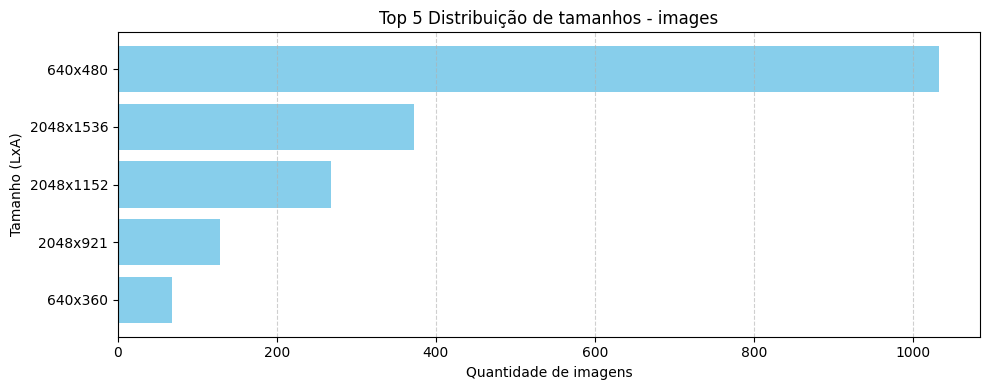


📊 Total de imagens analisadas em 'images': 333

🧠 Top 5 disposições por tamanho (LARGURA x ALTURA):

  - 640x480: 174 imagens
  - 2048x1536: 35 imagens
  - 2048x1152: 19 imagens
  - 640x360: 9 imagens
  - 2048x921: 6 imagens


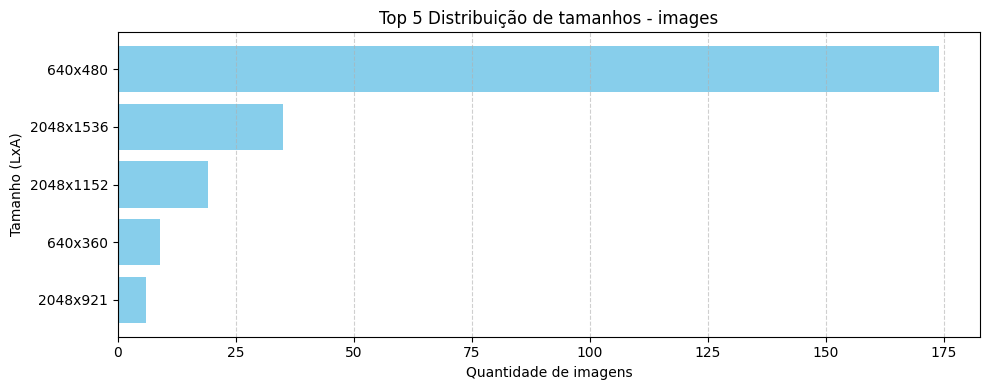


📊 Total de imagens analisadas em 'images': 162

🧠 Top 5 disposições por tamanho (LARGURA x ALTURA):

  - 640x480: 118 imagens
  - 2048x1536: 6 imagens
  - 2048x1152: 6 imagens
  - 640x360: 3 imagens
  - 2048x921: 2 imagens


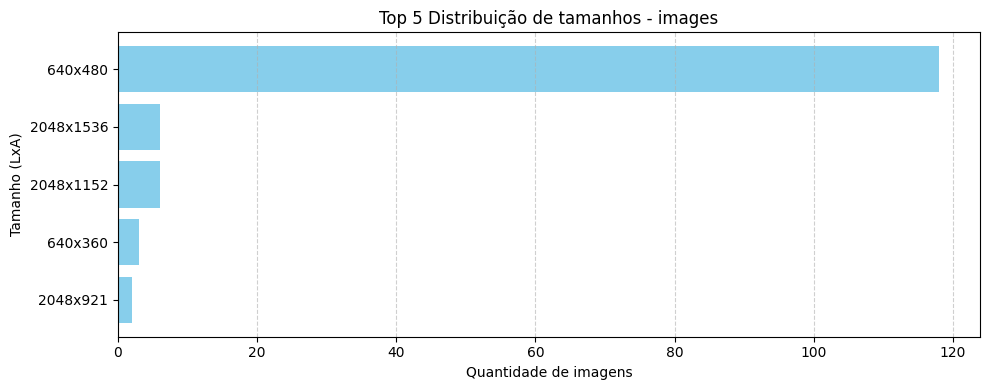


🔗 Top agregado (todos os splits juntos):
  - 640x480: 1325 imagens
  - 2048x1536: 413 imagens
  - 2048x1152: 293 imagens
  - 2048x921: 136 imagens
  - 640x360: 80 imagens


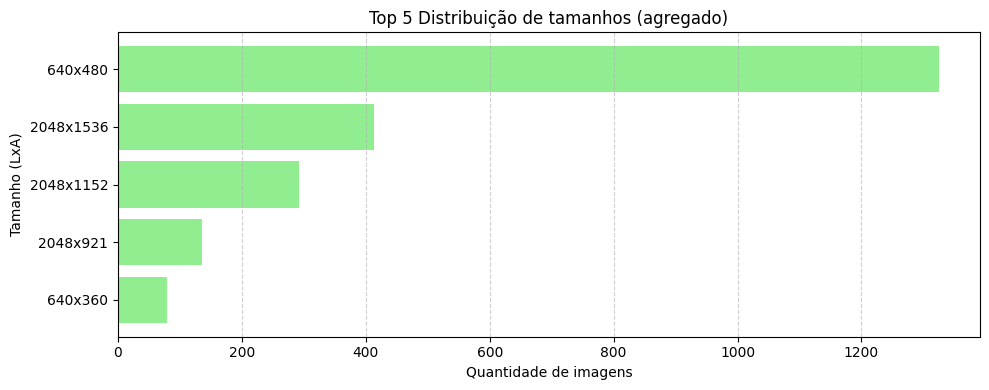

In [ ]:
from collections import Counter
import random
import matplotlib.pyplot as plt
import os

# dataset_path e sub_path já definidos anteriormente no notebook
dataset_path = "./merged_dataset_norang"
sub_path = ["train", "valid", "test"]

def analyze_image_sizes(path, top_n=5, sample_frac=None, use_pil=True, show_plot=True):
    exts = {'.jpg', '.jpeg', '.png'}
    entries = []

    if not os.path.isdir(path):
        print(f"Caminho não encontrado: {path}")
        return Counter()

    with os.scandir(path) as it:
        for e in it:
            if not e.is_file():
                continue
            if os.path.splitext(e.name)[1].lower() in exts:
                entries.append(e.path)

    if sample_frac is not None and 0 < sample_frac < 1 and len(entries) > 0:
        k = max(1, int(len(entries) * sample_frac))
        entries = random.sample(entries, k)

    counter = Counter()
    total = 0

    for p in entries:
        try:
            if use_pil:
                with Image.open(p) as im:
                    w, h = im.size
            else:
                import cv2
                img = cv2.imread(p)
                if img is None:
                    raise ValueError("cv2 failed to load")
                h, w = img.shape[:2]
        except Exception:
            continue

        counter[(w, h)] += 1
        total += 1

    print(f"\nTotal de imagens analisadas em '{os.path.basename(path)}': {total}\n")
    if not counter:
        print("Nenhuma imagem válida encontrada.")
        return counter

    items_to_show = counter.most_common(top_n if top_n is not None else None)
    print(f"Top {len(items_to_show)} disposições por tamanho (LARGURA x ALTURA):\n")
    for (w, h), cnt in items_to_show:
        print(f"  - {w}x{h}: {cnt} imagens")

    if show_plot:
        sizes = [f"{w}x{h}" for (w, h), _ in items_to_show]
        counts = [c for _, c in items_to_show]

        plt.figure(figsize=(10, max(4, len(sizes) * 0.6)))
        plt.barh(sizes[::-1], counts[::-1], color="skyblue")
        plt.xlabel("Quantidade de imagens")
        plt.ylabel("Tamanho (LxA)")
        plt.title(f"Top {len(sizes)} Distribuição de tamanhos - {os.path.basename(path)}")
        plt.grid(axis="x", linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    return counter

def analyze_dataset_subpaths(dataset_path, sub_paths, top_n=5, sample_frac=None, use_pil=True, show_plot=True, images_subfolder="images"):
    """
    Para cada sub_path em sub_paths, tenta analisar:
      1) dataset_path/sub_path/images
      2) dataset_path/sub_path
    Retorna dict {sub_path: Counter} e um Counter agregado.
    """
    results = {}
    aggregated = Counter()

    for sp in sub_paths:
        # prioriza pasta "images" dentro de cada split
        candidate1 = os.path.join(dataset_path, sp, images_subfolder)
        candidate2 = os.path.join(dataset_path, sp)
        if os.path.isdir(candidate1):
            path_to_scan = candidate1
        elif os.path.isdir(candidate2):
            path_to_scan = candidate2
        else:
            print(f"Subpath não encontrado (nem '{images_subfolder}'): {sp}")
            results[sp] = Counter()
            continue

        cnt = analyze_image_sizes(path=path_to_scan, top_n=top_n, sample_frac=sample_frac, use_pil=use_pil, show_plot=show_plot)
        results[sp] = cnt
        aggregated.update(cnt)

    # Mostrar top agregado
    if aggregated:
        print("\nTop agregado (todos os splits juntos):")
        for (w, h), c in aggregated.most_common(top_n if top_n is not None else None):
            print(f"  - {w}x{h}: {c} imagens")

        # plot agregado
        if show_plot:
            items = aggregated.most_common(top_n if top_n is not None else None)
            sizes = [f"{w}x{h}" for (w, h), _ in items]
            counts = [c for _, c in items]
            plt.figure(figsize=(10, max(4, len(sizes) * 0.6)))
            plt.barh(sizes[::-1], counts[::-1], color="lightgreen")
            plt.xlabel("Quantidade de imagens")
            plt.ylabel("Tamanho (LxA)")
            plt.title(f"Top {len(sizes)} Distribuição de tamanhos (agregado)")
            plt.grid(axis="x", linestyle="--", alpha=0.6)
            plt.tight_layout()
            plt.show()

    return results, aggregated

results_by_split, aggregated = analyze_dataset_subpaths(dataset_path, sub_path, top_n=5, sample_frac=None, use_pil=True, show_plot=True)


📊 Total de imagens analisadas em 'images': 851

🧠 Top 5 disposições por tamanho (LARGURA x ALTURA):

  - 640x480: 446 imagens
  - 2048x1536: 47 imagens
  - 2048x1152: 44 imagens
  - 2048x921: 26 imagens
  - 640x360: 25 imagens


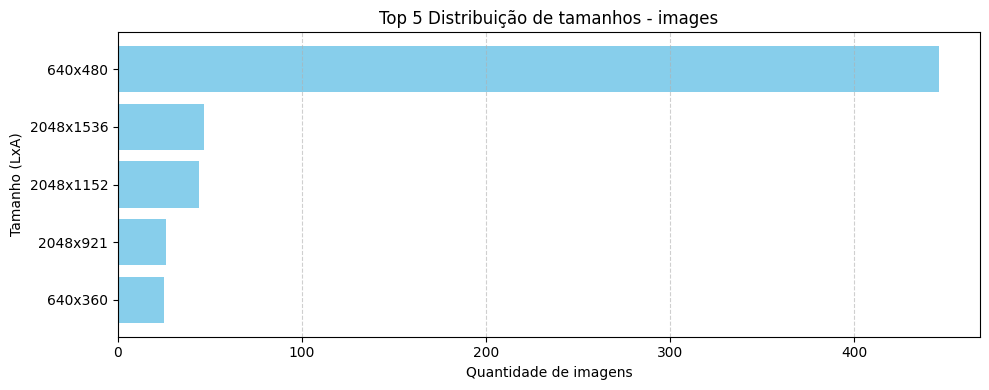


📊 Total de imagens analisadas em 'images': 134

🧠 Top 5 disposições por tamanho (LARGURA x ALTURA):

  - 640x480: 65 imagens
  - 2048x1152: 13 imagens
  - 2048x1536: 9 imagens
  - 640x360: 4 imagens
  - 2048x1001: 3 imagens


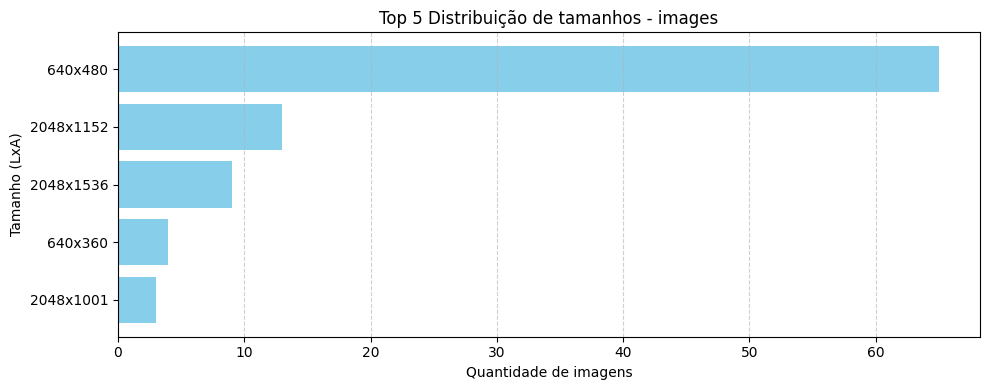


📊 Total de imagens analisadas em 'images': 327

🧠 Top 5 disposições por tamanho (LARGURA x ALTURA):

  - 640x480: 174 imagens
  - 2048x1536: 29 imagens
  - 2048x1152: 19 imagens
  - 640x360: 9 imagens
  - 2048x921: 6 imagens


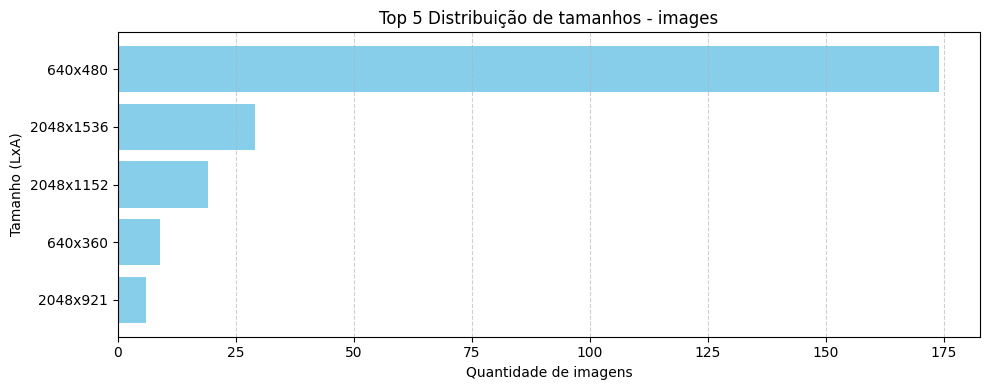


🔗 Top agregado (todos os splits juntos):
  - 640x480: 685 imagens
  - 2048x1536: 85 imagens
  - 2048x1152: 76 imagens
  - 640x360: 38 imagens
  - 2048x921: 35 imagens


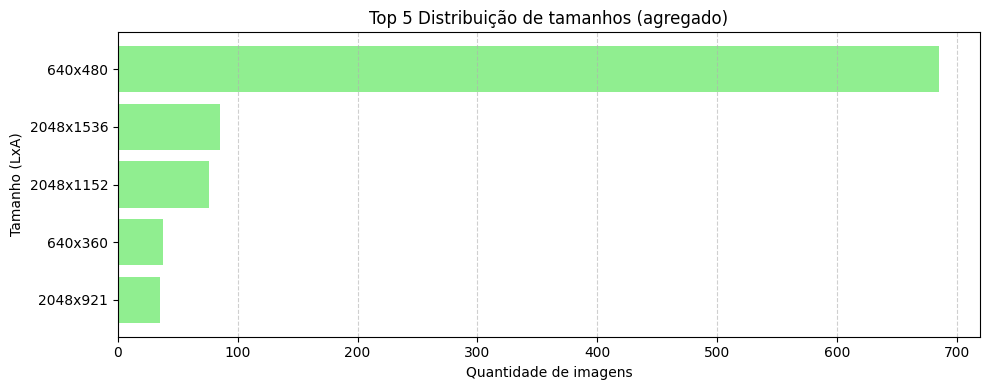

({'train': Counter({(640, 480): 446,
           (2048, 1536): 47,
           (2048, 1152): 44,
           (2048, 921): 26,
           (640, 360): 25,
           (640, 288): 14,
           (2048, 899): 12,
           (640, 640): 7,
           (640, 280): 6,
           (480, 640): 4,
           (2048, 1055): 4,
           (2048, 1442): 3,
           (874, 180): 3,
           (640, 378): 3,
           (2047, 506): 3,
           (2048, 778): 3,
           (2048, 574): 3,
           (881, 201): 3,
           (2048, 1204): 3,
           (2048, 1826): 3,
           (2048, 1010): 3,
           (2048, 588): 3,
           (2048, 1468): 3,
           (1536, 2048): 3,
           (2048, 494): 3,
           (2048, 1353): 3,
           (2048, 1210): 3,
           (2048, 1695): 3,
           (2048, 1370): 3,
           (2048, 541): 2,
           (640, 312): 2,
           (640, 100): 2,
           (640, 116): 2,
           (2048, 808): 2,
           (624, 149): 2,
           (2048, 1110): 2,
          

In [ ]:
from collections import Counter
import random
import matplotlib.pyplot as plt
import os

# dataset_path e sub_path já definidos anteriormente no notebook
dataset_path = "./merged_dataset_converted"
sub_path = ["train", "valid", "test"]

def analyze_image_sizes(path, top_n=5, sample_frac=None, use_pil=True, show_plot=True):
    exts = {'.jpg', '.jpeg', '.png'}
    entries = []

    if not os.path.isdir(path):
        print(f"Caminho não encontrado: {path}")
        return Counter()

    with os.scandir(path) as it:
        for e in it:
            if not e.is_file():
                continue
            if os.path.splitext(e.name)[1].lower() in exts:
                entries.append(e.path)

    if sample_frac is not None and 0 < sample_frac < 1 and len(entries) > 0:
        k = max(1, int(len(entries) * sample_frac))
        entries = random.sample(entries, k)

    counter = Counter()
    total = 0

    for p in entries:
        try:
            if use_pil:
                with Image.open(p) as im:
                    w, h = im.size
            else:
                import cv2
                img = cv2.imread(p)
                if img is None:
                    raise ValueError("cv2 failed to load")
                h, w = img.shape[:2]
        except Exception:
            continue

        counter[(w, h)] += 1
        total += 1

    print(f"\nTotal de imagens analisadas em '{os.path.basename(path)}': {total}\n")
    if not counter:
        print("Nenhuma imagem válida encontrada.")
        return counter

    items_to_show = counter.most_common(top_n if top_n is not None else None)
    print(f"Top {len(items_to_show)} disposições por tamanho (LARGURA x ALTURA):\n")
    for (w, h), cnt in items_to_show:
        print(f"  - {w}x{h}: {cnt} imagens")

    if show_plot:
        sizes = [f"{w}x{h}" for (w, h), _ in items_to_show]
        counts = [c for _, c in items_to_show]

        plt.figure(figsize=(10, max(4, len(sizes) * 0.6)))
        plt.barh(sizes[::-1], counts[::-1], color="skyblue")
        plt.xlabel("Quantidade de imagens")
        plt.ylabel("Tamanho (LxA)")
        plt.title(f"Top {len(sizes)} Distribuição de tamanhos - {os.path.basename(path)}")
        plt.grid(axis="x", linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    return counter

def analyze_dataset_subpaths(dataset_path, sub_paths, top_n=5, sample_frac=None, use_pil=True, show_plot=True, images_subfolder="images"):
    """
    Para cada sub_path em sub_paths, tenta analisar:
      1) dataset_path/sub_path/images
      2) dataset_path/sub_path
    Retorna dict {sub_path: Counter} e um Counter agregado.
    """
    results = {}
    aggregated = Counter()

    for sp in sub_paths:
        # prioriza pasta "images" dentro de cada split
        candidate1 = os.path.join(dataset_path, sp, images_subfolder)
        candidate2 = os.path.join(dataset_path, sp)
        if os.path.isdir(candidate1):
            path_to_scan = candidate1
        elif os.path.isdir(candidate2):
            path_to_scan = candidate2
        else:
            print(f"Subpath não encontrado (nem '{images_subfolder}'): {sp}")
            results[sp] = Counter()
            continue

        cnt = analyze_image_sizes(path=path_to_scan, top_n=top_n, sample_frac=sample_frac, use_pil=use_pil, show_plot=show_plot)
        results[sp] = cnt
        aggregated.update(cnt)

    # Mostrar top agregado
    if aggregated:
        print("\nTop agregado (todos os splits juntos):")
        for (w, h), c in aggregated.most_common(top_n if top_n is not None else None):
            print(f"  - {w}x{h}: {c} imagens")

        # plot agregado
        if show_plot:
            items = aggregated.most_common(top_n if top_n is not None else None)
            sizes = [f"{w}x{h}" for (w, h), _ in items]
            counts = [c for _, c in items]
            plt.figure(figsize=(10, max(4, len(sizes) * 0.6)))
            plt.barh(sizes[::-1], counts[::-1], color="lightgreen")
            plt.xlabel("Quantidade de imagens")
            plt.ylabel("Tamanho (LxA)")
            plt.title(f"Top {len(sizes)} Distribuição de tamanhos (agregado)")
            plt.grid(axis="x", linestyle="--", alpha=0.6)
            plt.tight_layout()
            plt.show()

    return results, aggregated

results_by_split, aggregated = analyze_dataset_subpaths(dataset_path, sub_path, top_n=5, sample_frac=None, use_pil=True, show_plot=True)

In [ ]:
import os
import cv2
import numpy as np
import shutil
from tqdm import tqdm

# --- Função de pré-processamento ---
def preprocess_full_image(image):
    # Converter para escala de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Suavização
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)

    # Sharpening
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, kernel)

    final_img = cv2.cvtColor(sharpened, cv2.COLOR_GRAY2BGR)
    return final_img

# --- Caminhos de entrada e saída ---
input_dataset = "./merged_dataset_norang"
output_dataset = "./merged_dataset_norang_preprocessed"

splits = ["train", "valid", "test"]

# --- Criação da estrutura do novo dataset ---
for split in splits:
    os.makedirs(os.path.join(output_dataset, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dataset, split, "labels"), exist_ok=True)

# --- Aplicação do pré-processamento ---
for split in splits:
    input_img_dir = os.path.join(input_dataset, split, "images")
    input_lbl_dir = os.path.join(input_dataset, split, "labels")
    output_img_dir = os.path.join(output_dataset, split, "images")
    output_lbl_dir = os.path.join(output_dataset, split, "labels")

    img_files = [f for f in os.listdir(input_img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    print(f"\nProcessando conjunto: {split} ({len(img_files)} imagens)")

    for img_name in tqdm(img_files, desc=f"Pré-processando {split}"):
        img_path = os.path.join(input_img_dir, img_name)
        out_img_path = os.path.join(output_img_dir, img_name)

        # Aplicar o pré-processamento
        image = cv2.imread(img_path)
        if image is None:
            print(f"Erro ao ler {img_path}")
            continue

        processed = preprocess_full_image(image)
        cv2.imwrite(out_img_path, processed)

        # Copiar label correspondente
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_src = os.path.join(input_lbl_dir, label_name)
        label_dst = os.path.join(output_lbl_dir, label_name)

        if os.path.exists(label_src):
            shutil.copy(label_src, label_dst)

print("\nPré-processamento completo! Novo dataset salvo em:")
print(f"📂 {output_dataset}")


🧩 Processando conjunto: train (3066 imagens)


Pré-processando train: 100%|██████████| 3066/3066 [07:11<00:00,  7.11it/s]



🧩 Processando conjunto: valid (333 imagens)


Pré-processando valid: 100%|██████████| 333/333 [00:26<00:00, 12.70it/s]



🧩 Processando conjunto: test (162 imagens)


Pré-processando test: 100%|██████████| 162/162 [00:11<00:00, 14.11it/s]


✅ Pré-processamento completo! Novo dataset salvo em:
📂 ./merged_dataset_norang_preprocessed
